# Accessing 30-m global-scale historical Landsat cloud-free time-series (1997—2024+) in Copernicus Data Space Ecosystem (CDSE)

In this tutorial, you will learn how to access the global, cloud-free, and reconstructed historical Landsat spectral bands (1997--2024) using the [Copernicus Data Space Ecosystem (CDSE)](https://dataspace.copernicus.eu/). Compressing 30-m bimonthly times series from 1997 onwards, this dataset was produced by [OpenGeoHub Foundation](https://opengeohub.org/)  using the [GLAD Landsat Analysis Ready Data v2](https://glad.geog.umd.edu/ard/home) as the primary input for temporal aggregation and the imputation of missing values (see [Consoli et al., 2024](https://doi.org/10.7717/peerj.18585) for detailed methodology). 

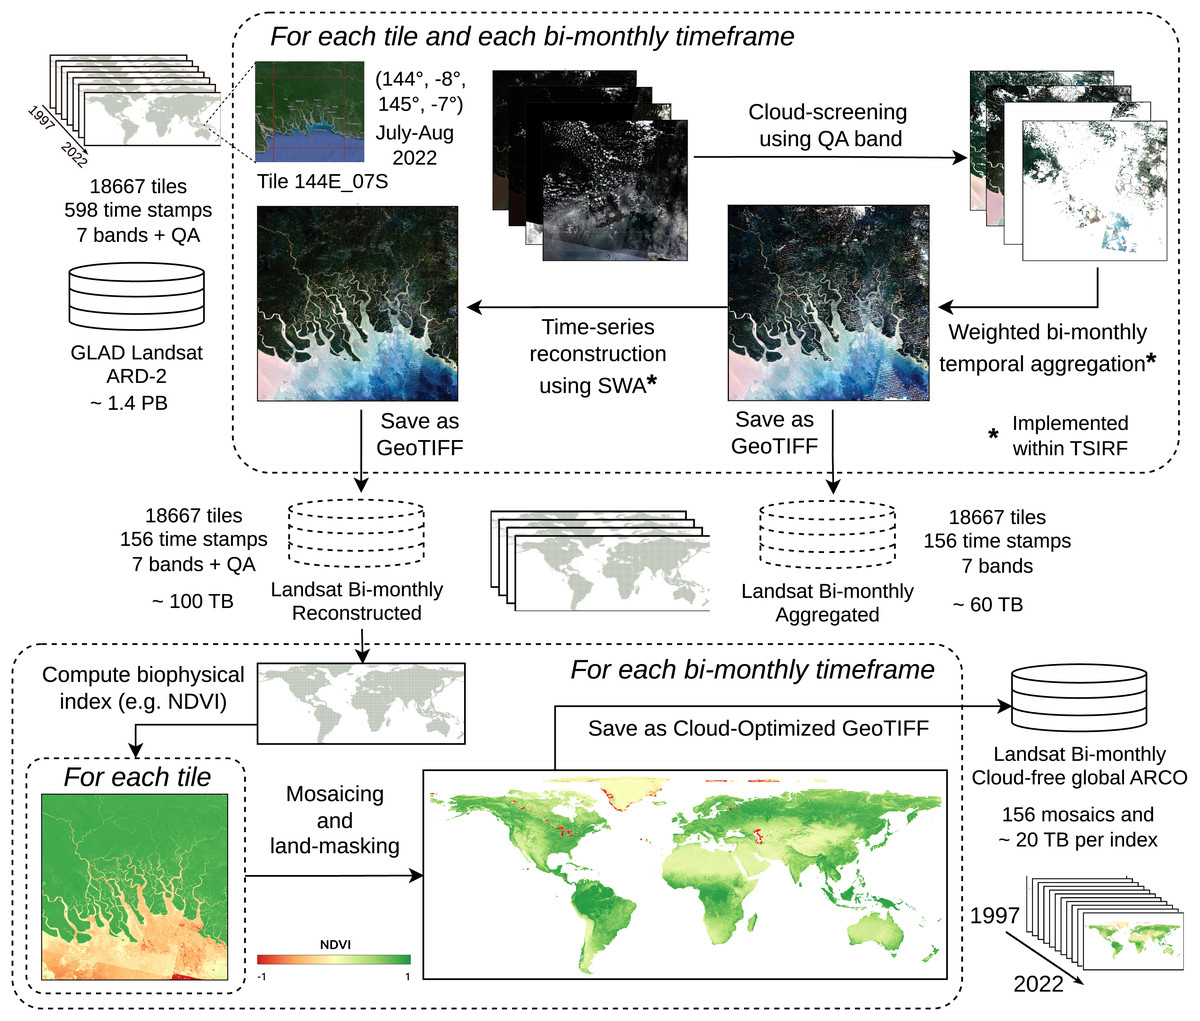

The dataset and the current tutorial was prepared under the scope of the Open-Earth-Monitor Cyberinfrastructure project, which has received funding from the European Union's Horizon Europe research and innovation programme under [grant agreement No. 101059548](https://cordis.europa.eu/project/id/101059548).

##  Copernicus Data Space Ecosystem (CDSE)

The Copernicus Data Space Ecosystem (CDSE) offers a wide range of infrastructure, services, and tools designed to unlock the full potential of Earth observation data. By fostering an open, dynamic, and ever-expanding ecosystem, CDSE enhances the impact of this data, driving innovation and supporting sustainable societal development.

First things first... to proceed with this you need to register and login in CDSE using the following link:
- https://dataspace.copernicus.eu

### JupyterLab

CDSE offer a several datasets & services, including a JupyterLab instance to run computation scripts in multiple languages (Python, R, Julia) close to Earth Observation imagery archives, which enables fast access to petabytes of data in a cloud environment. CDSE JupyterLab is accessible via the following link:

- https://jupyterhub.dataspace.copernicus.eu

For this tutorial you can choose a **medium server** option

Open the terminal and run the following clone the OEMC showcase repository:

In [ ]:
git clone https://github.com/Open-Earth-Monitor/showcase

Now, you should be able to open the computational notebook `showcase/OEMC_CDSE_landsat.ipynb`.

It's important to make sure that the kernel `Geo Science` is selected on the top-left corner.
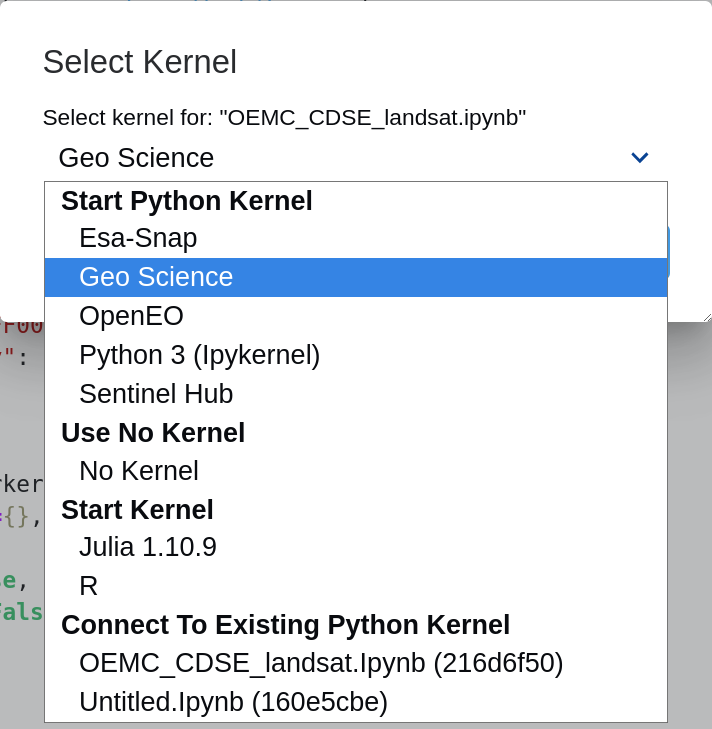

### CDSE STAC/S3 setup

In this tutorial, we will use access the global bimonthly landsat mosaics via STAC & S3. 

The [STAC access](https://browser.stac.dataspace.copernicus.eu/?.language=en) is open and does not require any authentication, however it provides only imagery metadata (_spatial extent, time period, etc_). To access the actual data, in [Cloud-Optimized GeoTIFF (COG)](https://cogeo.org/), you need to setup your S3 credentials, which can be generated following the instructions in official documentation:
- https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets

Once you generated your secrets and key copy them into the following variables:

In [ ]:
S3_ENDPOINT = "eodata.dataspace.copernicus.eu"

ACCESS_KEY = "<ACCESS_KEY>"
SECRET_KEY = "<SECRET_KEY>"

### Installing additional packages

To facilitate the interaction with dataset, we will use [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) to select some region of interest and collect points in a interactive webmap. So let's install the following packages:

In [ ]:
!pip install --upgrade ipywidgets
!pip install --upgrade ipyleaflet
!pip install seaborn
!pip install -e 'git+https://github.com/openlandmap/scikit-map#egg=scikit-map[full]'

## Region of interest

Considering that the dataset is global, you can use the webmap to select any region of interest in the World by drawing a regular rectangle. 

For a purpose of example, the webmap is centered in a agriculture area in Brazil, at municipality of Sorriso (MT) wiht zoom level 12.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from ipyleaflet import Map, basemaps, basemap_to_tiles, GeomanDrawControl, LayersControl

mapnik = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
mapnik.base = True
mapnik.name = 'Mapnik Layer'

esri = basemap_to_tiles(basemaps.Esri.WorldImagery)
esri.base = True
esri.name = 'Esri WorldImagery'

m = Map(center=(-12.5807, -55.9686), zoom = 12, layers=[esri, mapnik])

draw_control = GeomanDrawControl(
    rectangle={
        "pathOptions": {
            "fillColor": "#FF0000", 
            "color": "#FF0000",
            "fillOpacity": 0.5,
            "weight": 3
        }
    },
    marker={}, circlemarker={},
    circle={}, polyline={},
    polygon={},
    edit=False, cut=False,
    remove=False, drag=False,
    rotate=False
)

m.add_control(draw_control)
m.add_control(LayersControl())
m

Now, you need to extract the drawn rectangle and convert it a [shapely.geometry]().

In [ ]:
from shapely.geometry import shape
from shapely import to_geojson
import json

# Use it in case of issues running ipyleaflet
#fallback_geometry = {'type': 'Polygon',
# 'coordinates': [[[-56.055536, -12.63809],
#   [-56.055536, -12.523493],
#   [-55.88178, -12.523493],
#   [-55.88178, -12.63809],
#   [-56.055536, -12.63809]]]}

geometry = shape(draw_control.data[-1]['geometry'])
bounds = geometry.bounds

print(f"Bounds: {bounds}")
print("Geometry:", json.loads(to_geojson(geometry)))

## CDSE STAC

CDSE provides a dynamic Spatio-Temporal Asset Catalog (STAC), which is providing the most recent satellite images obtained by Copernicus program, as well as other EO data set (`Copernicus Land Monitoring Services`, bi-monthly Landsat mosaics, etc).

Let's use the package `pystac_client` to create a catalog connection and query the bi-monthly Landsat mosaics,

In [ ]:
import pystac_client

CDSE_URL = "https://stac.dataspace.copernicus.eu/v1"
cat = pystac_client.Client.open(CDSE_URL)
cat.add_conforms_to("ITEM_SEARCH")

...for a specific date period,

In [ ]:
start_dt = "2000-01-01"
end_dt = "2002-12-31"

... and considering the region of interest defined earlier via ipyleaflet:

In [ ]:
from shapely import to_geojson
import json

params = {
    "collections": ["opengeohub-landsat-bimonthly-mosaic-v1.0.1"],
    "intersects": json.loads(to_geojson(geometry)),
    "datetime": f"{start_dt}T00:00:00Z/{end_dt}T23:59:59Z",
    "sortby": [
        {"field": "properties.start_datetime", "direction": "desc"}
    ],
    "fields": {"exclude": ["geometry"]}
}

Once all parameters are set, you need to send the request via `search` method:

In [ ]:
items = list(cat.search(**params).items_as_dicts())
print(f"Number of STAC items returned: {len(items)}")

Let's take a look in the first two items returned:

In [ ]:
items[0]

### Creating DataArray 

One of the most convenient ways to interact with STAC is using the package stackstac, which creates a xarray.DataArray based on a set of STAC Items and enables multi-dimension aggregation operations and lazy-loading:

In [ ]:
import rioxarray 
import stackstac

stack = stackstac.stack(
    items=items,
    resolution=(0.00025, 0.00025),
    bounds_latlon=bounds,
    epsg=4326,
    gdal_env=stackstac.DEFAULT_GDAL_ENV.updated(
        {
            "GDAL_NUM_THREADS": -1,
            "GDAL_HTTP_UNSAFESSL": "YES",
            "GDAL_HTTP_TCP_KEEPALIVE": "YES",
            "AWS_VIRTUAL_HOSTING": "FALSE",
            "AWS_HTTPS": "YES",
        }
    ),
)

stack

By default, the DataArray does not populate the time dimension for the bi-monthly landsat mosaics. 

To fix that, you can to derive the middle data for each bi-monthly period directly from the STACItems and assing to the DataArray:

In [ ]:
from datetime import datetime

mid_dts = []

for i in items:
    end_datetime = datetime.strptime(i['properties']['end_datetime'], "%Y-%m-%dT%H:%M:%S.%fZ")
    start_datetime = datetime.strptime(i['properties']['start_datetime'], "%Y-%m-%dT%H:%M:%S.%fZ")
    mid_datetime = start_datetime +  (end_datetime - start_datetime) / 2    
    mid_dts.append(mid_datetime)

stack = stack.assign_coords(time=mid_dts)

In [ ]:
stack

The bi-monthly landsat mosaics are organized in tiles (1x1 degree), 8 bands (`B01—07 + clear_sky_mask`) and 6 bi-monthly periods per year, thus each individual COG file represent a single tile, band and bi-monthly period.

So, if your region of interest is covered by multiple tiles, the `DataArray` need to be grouped/collapsed by `time` dimension. Considering that the tiles have no overlap, the grouping can occur by the operation `first`. 

Specifically for the example of this tutorial in Brazil (Sorriso/MT), the region of interest is covered by two tiles, and after the grouping the number of values on the `time` dimension must be two times lower then what was retrieved via STAC.

In [ ]:
stack = stack.groupby('time').first()
stack

To facilitate the identification of selected region of interested, you need to add a attribute `region_label` in the DataArray:

In [ ]:
stack.attrs['region_label'] = 'brazil_sorriso'

To make sure that GDAL will be able to access the Landsat individual COG files via S3, you need to setup the credentials and endpoint as environmental variables for [/vsis3/](https://gdal.org/en/stable/user/virtual_file_systems.html#vsis3-aws-s3-files):

In [ ]:
import os
os.environ["AWS_S3_ENDPOINT"] = S3_ENDPOINT
os.environ["AWS_ACCESS_KEY_ID"] = ACCESS_KEY
os.environ["AWS_SECRET_ACCESS_KEY"] = SECRET_KEY

### Color Composities

The bi-monthly Landsat mosaics have the following spectral bands harmonized across all Landsat mission (5,7,8 & 9) according to [Potapov et al., 2020](https://doi.org/10.3390/rs12030426) by [GLAD team (University of Maryland)](https://glad.geog.umd.edu/):

- **B01**: Blue
- **B02**: Green
- **B03**: Red
- **B04**: Near Infrared (NIR)
- **B05**: Short wave Infrared 1 (SWIR-1)
- **B06**: Short wave Infrared 2 (SWIR-2)
- **B07**: Thermal

An additional band (`clear_sky_mask`) is provided to flag which pixels were cloud free (`value=1`) and were not interpolated by [Consoli et al., 2024](https://doi.org/10.7717/peerj.18585) in the final product.

For better visualize the data, let's select a [color composite](https://gsp.humboldt.edu/olm/Courses/GSP_216/lessons/composites.html) and filter the `DataArray` only for specific bands:

In [ ]:
band_s2nr = ['B06', 'B04', 'B03'] # SWIR-2, NIR, RED
band_ns1r = ['B04', 'B05', 'B03'] # NIR, SWIR-1, RED
band_rgb  = ["B03", "B02", "B01"] # RED, GREEN, BLUE

composite = stack.sel(band=band_ns1r)

All DataArray operations have been [lazy-loaded](https://docs.xarray.dev/en/latest/internals/internal-design.html#lazy-loading) so far, meaning the Landsat pixels haven't been accessed yet. You'll need to use the `compute` method to execute the data access:

In [ ]:
composite_local = composite.sortby("time", ascending=True).compute()

Now that Landsat data is in memory, let's visualize all the time series,

In [ ]:
composite_local.plot.imshow(col="time", rgb="band", col_wrap=6, robust=True)

... and produce a animation using the package [geogif](https://github.com/gjoseph92/geogif):

In [ ]:
from geogif import gif, dgif
gif(composite_local, fps=2)

Once the data in is memory, it's quite straightforward save it locally in the folder `landsat_export`:

In [ ]:
from pathlib import Path
import numpy as np

# Responsible to define the name of
# the geotiff outfile 
def outname(c):
    product = c['product:type'].values
    mid_dt = np.datetime64(c.time.values)
    start_dt = np.datetime_as_string(mid_dt.astype('M8[M]') - np.timedelta64(1,'M'), unit='D')
    end_dt = np.datetime_as_string(mid_dt.astype('M8[M]') + np.timedelta64(1,'M')  - np.timedelta64(1,'D'), unit='D')
    band = "-".join(c.band.values)
    region = c.attrs['region_label']
    return f"{product}_{start_dt}_{end_dt}_{band}_{region}.tif"

outdir = 'landsat_export'
Path(outdir).mkdir(exist_ok=True)

for c in composite_local:
    outfile = f"{outdir}/{outname(c)}"
    print(f"Saving {outfile}")
    c.rio.to_raster(outfile, dtype='uint8', tiled=True, compress="DEFLATE")

### Spectal Indices  

Now, let's do the same approach for a spectral index computed on-the-fly.

First, we need to select input bands and rescale the pixel values from 0—250 to 0—1 range. This operation is performed by multiplying pixel values to `0.004`.

In [ ]:
# Scale values to 0--1

nir = stack.sel(band="B04") * 0.004
red = stack.sel(band="B03") * 0.004
blue = stack.sel(band="B01") * 0.004

Later, we can compute **Normalized Difference Vegetation Index (NDVI)** and **Enhanced Vegetation Index (EVI)**:

In [ ]:
# Compute indices on the fly
ndvi = (nir - red) / (nir + red)
evi = 2.5 * ( (nir - red) / (nir + 6 * red - 7.5 * blue + 1) )

Let's call the compute method to move the data to local memory and copy all attributes from original DataArray,

In [ ]:
evi = evi.compute()
evi.attrs = stack.attrs

...visualize all the time series,

In [ ]:
evi.plot.imshow(col="time", cmap='RdYlGn', col_wrap=6, robust=True)

...and animate that.

In [ ]:
from geogif import gif, dgif
gif(evi, cmap='RdYlGn', fps=2)

Lastly, let's save it locally in the folder `landsat_export`:

In [ ]:
from pathlib import Path
import numpy as np

def outname(c, index):
    product = c['product:type'].values
    mid_dt = np.datetime64(c.time.values)
    start_dt=np.datetime_as_string(mid_dt.astype('M8[M]') - np.timedelta64(1,'M'), unit='D')
    end_dt=np.datetime_as_string(mid_dt.astype('M8[M]') + np.timedelta64(1,'M')  - np.timedelta64(1,'D'), unit='D')
    region = c.attrs['region_label']
    return f"{product}_{start_dt}_{end_dt}_{index}_{region}.tif"

outdir = 'landsat_export'
Path(outdir).mkdir(exist_ok=True)

for c in evi:
    index = 'evi'
    outfile = f"{outdir}/{outname(c, index)}"
    print(f"Saving {outfile}")
    c.rio.to_raster(outfile, dtype='float32', tiled=True, compress="DEFLATE")

## S3 Access

### scikit-map

[scikit-map](https://github.com/openlandmap/scikit-map?tab=readme-ov-file) is library to produce maps using **machine learning**, **reference samples** and **raster data**. It is fully compatible with [scikit-learn](https://scikit-learn.org/) and distributed under the MIT license. This library is currently operational and maintained mainly by OpenGeoHub Fundation.

### Drawn points
To mimic the reference sample points, you can draw points using interactive leaflet and export to GeoPandas format.

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from ipyleaflet import Map, basemaps, basemap_to_tiles, GeomanDrawControl, LayersControl

mapnik = basemap_to_tiles(basemaps.OpenStreetMap.Mapnik)
mapnik.base = True
mapnik.name = 'Mapnik Layer'

esri = basemap_to_tiles(basemaps.Esri.WorldImagery)
esri.base = True
esri.name = 'Esri WorldImagery'

m = Map(center=(-12.5807, -55.9686), zoom = 12, layers=[esri, mapnik])

draw_control = GeomanDrawControl(
    # --- ENABLE POINT TOOLS ---
    # Marker: A simple icon point.
    marker={'pathOptions': {'color': 'red'}},
    # CircleMarker: A fixed-radius circle point.
    circlemarker={'pathOptions': {'color': 'blue'}},
    
    # --- DISABLE ALL OTHER TOOLS ---
    circle={},        # Disables circle tool
    polyline={},      # Disables polyline tool
    polygon={},       # Disables polygon tool
    rectangle={},     # Disables rectangle tool
    
    # Disable editing tools if you only want collection
    allow_editing=False,
    allow_deleting=False
)

m.add_control(draw_control)
m.add_control(LayersControl())
m

In [ ]:
import numpy as np
import geopandas as gpd

coordinates = np.array([ feat['geometry']['coordinates'] for feat in draw_control.data ])
gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(x=coordinates[:,0], y=coordinates[:,1], crs='EPSG:4326'))
gdf_points['label'] = [ f'Point_{i+1}' for i in range(0,gdf_points.shape[0]) ]
gdf_points

### Landsat tiles
Laterly, we accessed the dataset from CDSE data catalog, but we can also access external cloud service and catalogue, for example, OpenGeoHub Foundation's cloud infrastructure.

In `https://s3.eu-central-1.wasabisys.com/ogh/landsat_mosaics_tiles.gpkg`, we documented the whole time series of our Landsat data from 1997-2024. We are going to leverage it to create s3 file link to access the whole time series (1997-2024 currently) from CDSE infrastructure.

In [ ]:
gdf_tiles = gpd.read_file('https://s3.eu-central-1.wasabisys.com/ogh/landsat_mosaics_tiles.gpkg')
split = gdf_tiles['TILE'].str.split('_',expand=True)
gdf_tiles['TILE'] = split[1] + split[0]
gdf_tiles.plot()

In [ ]:
tiles = gdf_tiles.sjoin(gdf_points)['TILE'].unique()
tiles

### VRT Generation
The CDSE dataset is generally oragnized by tiles. However, the selected points canlocate at not only one tile. To simply overlay provess we can create a virtual dataset (VRT) to mosaic tiles at the same timestamp to a single entry.

In [ ]:
def s3_urls(tiles, bands, y1=1997, y2=2024):
    months = ['01-02', '03-04', '05-06', '07-08', '09-10', '11-12']
    
    urls = {}
    for y in range(y1,y2+1):
        for m in months:
            for b in bands:
                key = f'Landsat_mosaic_{y}_{m}_{b}'
                urls[key] = [
                    f's3://eodata/Global-Mosaics/Landsat/OLM_SWA_ARD2/v1/{y}/{m.split("-")[0]}/01/Landsat_mosaic_{y}_{m}_{t}_V1.0.1/{b}_{y}.tif'
                    for t in tiles 
                ]
    
    return urls

urls = s3_urls(tiles, ['B03','B04'])

In [ ]:
urls['Landsat_mosaic_1997_01-02_B03']

In [ ]:
from osgeo.gdal import BuildVRT
from rasterio.session import AWSSession
from pathlib import Path
import rasterio
outdir = 'vrt_export'
Path(outdir).mkdir(exist_ok=True)

session = AWSSession(
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    region_name="default",
    endpoint_url=S3_ENDPOINT)

# Use rasterio.Env to pass the custom session:
with rasterio.Env(session=session, AWS_VIRTUAL_HOSTING=False):
    for key in urls.keys():
        outfile = f'{outdir}/{key}.vrt'
        print(f"Creating {outfile}")
        BuildVRT(outfile, [ u.replace('s3://','/vsis3/') for u in urls[key] ])

In [ ]:
from skmap.misc import find_files
vrt_files = find_files('vrt_export','*.vrt')
print('Number of VRT files:', len(vrt_files))

### Point overlay
Afterwards, we can run the overlaying function. The function will take the reference points, extract the pixel value at each timestamp for each band and create/append a column. Each point will have the same amount of timestamp value as columns. The number of columns will be (*bands* x *timestamp*)

In [ ]:
from pathlib import Path
from skmap.mapper import SpaceOverlay, SpaceTimeOverlay

with rasterio.Env(session=session, AWS_VIRTUAL_HOSTING=False):
    overlay = SpaceOverlay(points=gdf_points, fn_layers=vrt_files, verbose=True)
    overlaid_samples = overlay.run()
    overlaid_samples

In [ ]:
# derive NDVI of overlaid points
red_cols = overlaid_samples.columns[overlaid_samples.columns.str.contains('B03')].sort_values()
nir_cols = overlaid_samples.columns[overlaid_samples.columns.str.contains('B04')].sort_values()
ndvi_cols = nir_cols.str.replace('B04','NDVI')

red = overlaid_samples[red_cols].to_numpy()
nir = overlaid_samples[nir_cols].to_numpy()

overlaid_samples[ndvi_cols] = (nir - red) / (nir + red)

### Time-series analysis

The random assigned sample points can scatter around forest, grasslands, cropland, or even man-made structure and water. They all illustrate different patterns in a  time series of spectral indices, in our exmaple, NDVI. Let's plot the time-seris of NDVI of each point and discuss what you find.

In [ ]:
# create dataframe for NDVI
ndvi_df = overlaid_samples[ndvi_cols].T

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# tune the figure parameters
time_stamps=['_'.join(i.split('_')[2:4]) for i in ndvi_df.index]
years = [ts.split("_")[0] for ts in time_stamps]
xtick_positions = list(range(0, len(time_stamps), 6))
xtick_labels = [years[i] for i in xtick_positions]
# set Seaborn style and context
sns.set(style="whitegrid", palette="tab10", context="notebook")

# create subplots with shared y-axis
point_num = len(ndvi_df.columns)
fig, axs = plt.subplots(point_num, 1, figsize=(12, 3*point_num), sharey=True, constrained_layout=True)

for i in range(point_num):
    sns.lineplot(
        x=time_stamps, 
        y=ndvi_df.iloc[:, i], 
        marker="o", 
        ax=axs[i], 
        label=f"NDVI time-series of point {i}"
    )
    
    axs[i].legend()
    axs[i].set_xticks(xtick_positions)
    axs[i].set_xticklabels(xtick_labels, rotation=45)
    axs[i].set_ylabel("NDVI")  # Optional: add y-axis label

plt.show()


## Machine learning

To demonstrate the ML modeling using Landsat data, let's use some reference samples obtained by the [Global Pasture Watch project](https://github.com/wri/global-pasture-watch) for a area of 1 km2. The full set of samples are publicly available in Zenodo (https://doi.org/10.5281/zenodo.15631655).

In [ ]:
import pandas as pd
import geopandas as gpd

samples = gpd.read_file('https://s3.eu-central-1.wasabisys.com/ogh/gpw_grassland_fscs.vi.vhr.harm.overlaid_point.samples.tile.1483.gpkg')
samples['ref_date'] = pd.to_datetime(samples['year'], format='%Y')
samples

The column `class` have references for grassland (`value=1`) and others (`values=4`) land cover classes. 

Let's convert the class other to `value=0`,

In [ ]:
samples['class'] = samples['class'].replace(4,0)

...and check spatial distribution for each year separately:

In [ ]:
samples['year'].value_counts()

In [ ]:
for year, samples_y in samples.groupby('year'):
    ax = samples_y.plot(column='class', cmap='copper', legend=True)
    ax.set_title(f"Year {year}")

### VRT generation

Now, it's time to generate the URLs for all years where we have samples + some extra years (2000, 2020),

In [ ]:
def s3_urls(tiles, bands, years):
    months = ['01-02', '03-04', '05-06', '07-08', '09-10', '11-12']
    
    urls = {}
    for y in years:
        for m in months:
            for b in bands:
                key = f'Landsat_mosaic_{y}_{m}_{b}'
                urls[key] = [
                    f's3://eodata/Global-Mosaics/Landsat/OLM_SWA_ARD2/v1/{y}/{m.split("-")[0]}/01/Landsat_mosaic_{y}_{m}_{t}_V1.0.1/{b}_{y}.tif'
                    for t in tiles 
                ]
    
    return urls

bands = ['B02','B03','B04','B05','B06']
years = (['2000'] + sorted(list(samples['year'].unique())) + ['2020'])
tiles = gdf_tiles.sjoin(samples)['TILE'].unique()

urls = s3_urls(tiles, bands, years)
print(f"Number of URLs: {len(urls)}")

...and produce the VRT files for the spatiotemporal overlay & ML modeling.

In [ ]:
import rasterio
from osgeo.gdal import BuildVRT
from rasterio.session import AWSSession
from pathlib import Path

outdir = 'vrt_input'
Path(outdir).mkdir(exist_ok=True)

session = AWSSession(
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    region_name="default",
    endpoint_url=S3_ENDPOINT)

# Use rasterio.Env to pass the custom session:
with rasterio.Env(session=session, AWS_VIRTUAL_HOSTING=False):
    for key in urls.keys():
        outfile = f'{outdir}/{key}.vrt'
        print(f"Creating {outfile}")
        BuildVRT(outfile, [ u.replace('s3://','/vsis3/') for u in urls[key] ])

### Spatiotemporal overlay

To run the spatiotemporal overlay, the input raster files need to have a placeholder for the year,

In [ ]:
from skmap.misc import find_files
base_year = years[0]
raster_files = [ Path(str(v).replace(str(base_year),'{year}')) for v in find_files(outdir,f'*{base_year}*.vrt') ]

print(f"Number of files for year {base_year}: {len(raster_files)}")
print(f" {raster_files[0]}")

...which will be filled according to reference year of each sample (column `ref_date`):

In [ ]:
from pathlib import Path
from skmap.mapper import SpaceOverlay, SpaceTimeOverlay

with rasterio.Env(session=session, AWS_VIRTUAL_HOSTING=False):
    overlay = SpaceTimeOverlay(points=samples, col_date='ref_date', fn_layers=raster_files, verbose=True)
    overlaid_samples = overlay.run()
    overlaid_samples

### ML training

Now, we are ready to train a ML model using the overlaid values as features

In [ ]:
target = 'class'
features = sorted(overlaid_samples.columns.drop(list(samples.columns) + ['overlay_id']))

print(f"Number of features: {len(features)}")
print(f" - {features[0]}" )
print(f" - {features[-1]}" )

Let's train a naive Random Forest model using [scikit-learn](https://scikit-learn.org) and estimate the classification accuracy via [5-fold cross validation](https://scikit-learn.org/stable/modules/cross_validation.html):

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

pred = cross_val_predict(
    estimator=RandomForestClassifier(),
    X=overlaid_samples[features],
    y=overlaid_samples[target],
    cv=5)

print(classification_report(overlaid_samples[target], pred, target_names=["Others", "Grassland"]))

And train a final model for prediction using all the available samples:

In [ ]:
rf = RandomForestClassifier()
rf.fit(overlaid_samples[features], overlaid_samples[target])

### Prediction

We are finally ready to use the trained model to predict multiple years,

In [ ]:
import rasterio
from rasterio.windows import from_bounds
from skmap.io import read_rasters, save_rasters
from rasterio.session import AWSSession

def predict_year(rf, year, outfile, basedir='vrt_input'):
    vrt_files = find_files(basedir,f'*{year}*.vrt')
    src = rasterio.open(vrt_files[0])

    minx, miny, maxx, maxy = samples.total_bounds
    window = from_bounds(minx, miny, maxx, maxy, transform=src.transform).round_lengths()

    data = read_rasters(vrt_files, window=window)
    pred = rf.predict(data.reshape(-1, len(features))).reshape((data.shape[0],data.shape[1]))
    save_rasters(vrt_files[0], [outfile], pred, window=window)

session = AWSSession(
    aws_access_key_id=ACCESS_KEY,
    aws_secret_access_key=SECRET_KEY,
    region_name="default",
    endpoint_url=S3_ENDPOINT)

pred_files = []
with rasterio.Env(session=session, AWS_VIRTUAL_HOSTING=False):
    for year in years:
        print(f"Predicting year {year}")
        
        outfile = f'prediction_{year}.tif'
        predict_year(rf, year, outfile)
        
        pred_files.append(outfile)

...and visualize the result:

In [ ]:
from skmap.plotter import plot_rasters
plot_rasters(*pred_files, cmaps = "copper", titles = years)